<a href="https://colab.research.google.com/github/garkul/Transcriptomics.msu/blob/master/HW_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Домашнее задание 8</h1>
<h3> Гаркуль Лидия 4 курс ФББ</h3>

<b>Задание:</b><br>
1. Проверьте поведение проделанных в ходе семинара трансформаций на датасете Smart-seq2. Какие выводы вы можете сделать?
2. Постройте постройте аналогичный заданию из занятия боксплот с распределением квардарат коэффециента корреляции между экспрессией гена и глубиной секвенирования клетки, только добавьте туда также и корреляцию для остатков регрессии SCTransform (и Analytic Pearson residuals). Есть ли при таких трансформациях зависимость между глубиной секвенирования клетки и экспрессией генов?

### Скачиваем необходимые пакеты и программы

In [ ]:
!pip3 install scanpy[leiden] anndata2ri scikit-misc scvi-tools scvelo
!apt-get install libgmp3-dev libcairo2-dev libharfbuzz-dev libfribidi-dev libudunits2-dev
!gdown "1W0TuuQospxcasOX5cQdhT_Xd-k7-QAck&confirm=t"
!tar xf library.tar.gz

# Необходимо, чтобы конкретно прогрузился matplotlib
import os
os.kill(os.getpid(), 9)

In [ ]:
import anndata2ri
anndata2ri.activate()
!pip install rpy2==3.5.1
%load_ext rpy2.ipython
%R .libPaths("usr/local/lib/R/site-library/")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'/content/...,'/usr/loca...,'/usr/lib/...,'/usr/lib/...


In [ ]:
# Установка пакета glmGamPoi, необходимого для SCTransform
import rpy2.robjects as ro
ro.r('BiocManager::install("glmGamPoi")')

In [ ]:
import scanpy as sc
import seaborn as sns
import scvelo as scv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style("ticks")
sc.set_figure_params(dpi=150)

### 1. Проверьте поведение проделанных в ходе семинара трансформаций на датасете Smart-seq2. Какие выводы вы можете сделать?


In [ ]:
!gdown 1n97r-ye38uOxAr5b424L3W3P4rwahJ3C

Downloading...
From: https://drive.google.com/uc?id=1n97r-ye38uOxAr5b424L3W3P4rwahJ3C
To: /content/Smart-seq2.h5ad
100% 20.8M/20.8M [00:00<00:00, 158MB/s]


In [ ]:
adata_smart = sc.read_h5ad("Smart-seq2.h5ad")

In [ ]:
def f_NB(x, a):
  return x + a * x**2

def mean_var_plot(adata, fit_NB=False, fit_poly=False, log=True,
                  xlim=None, ylim=None):
  from scipy.optimize import curve_fit

  variances = np.var(adata.X.A, axis=0)
  means = adata.X.mean(axis=0).A[0][variances > 0]
  variances = variances[variances > 0]
  lim_min = min(np.min(means), np.min(variances))
  lim_max = max(np.max(means), np.max(variances))
  fig, ax = plt.subplots(figsize=(4, 4))
  ax.plot([lim_min - 0.5, lim_max + 0.5], [lim_min - 0.5, lim_max + 0.5],
          linewidth=1, color="grey", label="$Var(E) = E$")
  sns.scatterplot(x=means, y=variances, ax=ax, linewidth=0, s=3)
  if fit_NB:
    popt_NB, _ = curve_fit(f_NB, means, variances)
    fit_line_NB = np.array(range(int(lim_max))) * 0.01
    ax.plot(fit_line_NB, f_NB(fit_line_NB, *popt_NB), color="red", 
            label="$Var(E) = E + ${:.2f}$E^2$".format(popt_NB[0]))
  ax.set_ylabel("Variance")
  ax.set_xlabel("Mean")
  if log:
    ax.set_xscale("log")
    ax.set_yscale("log")
  if not(xlim is None):
    ax.set_xlim(left=xlim[0], right=xlim[1])
  else:
    ax.set_xlim(left=0, right=lim_max)
  if not(ylim is None):
    ax.set_ylim(bottom=ylim[0], top=ylim[1])
  else:
    ax.set_ylim(bottom=0, top=lim_max)
  ax.legend()

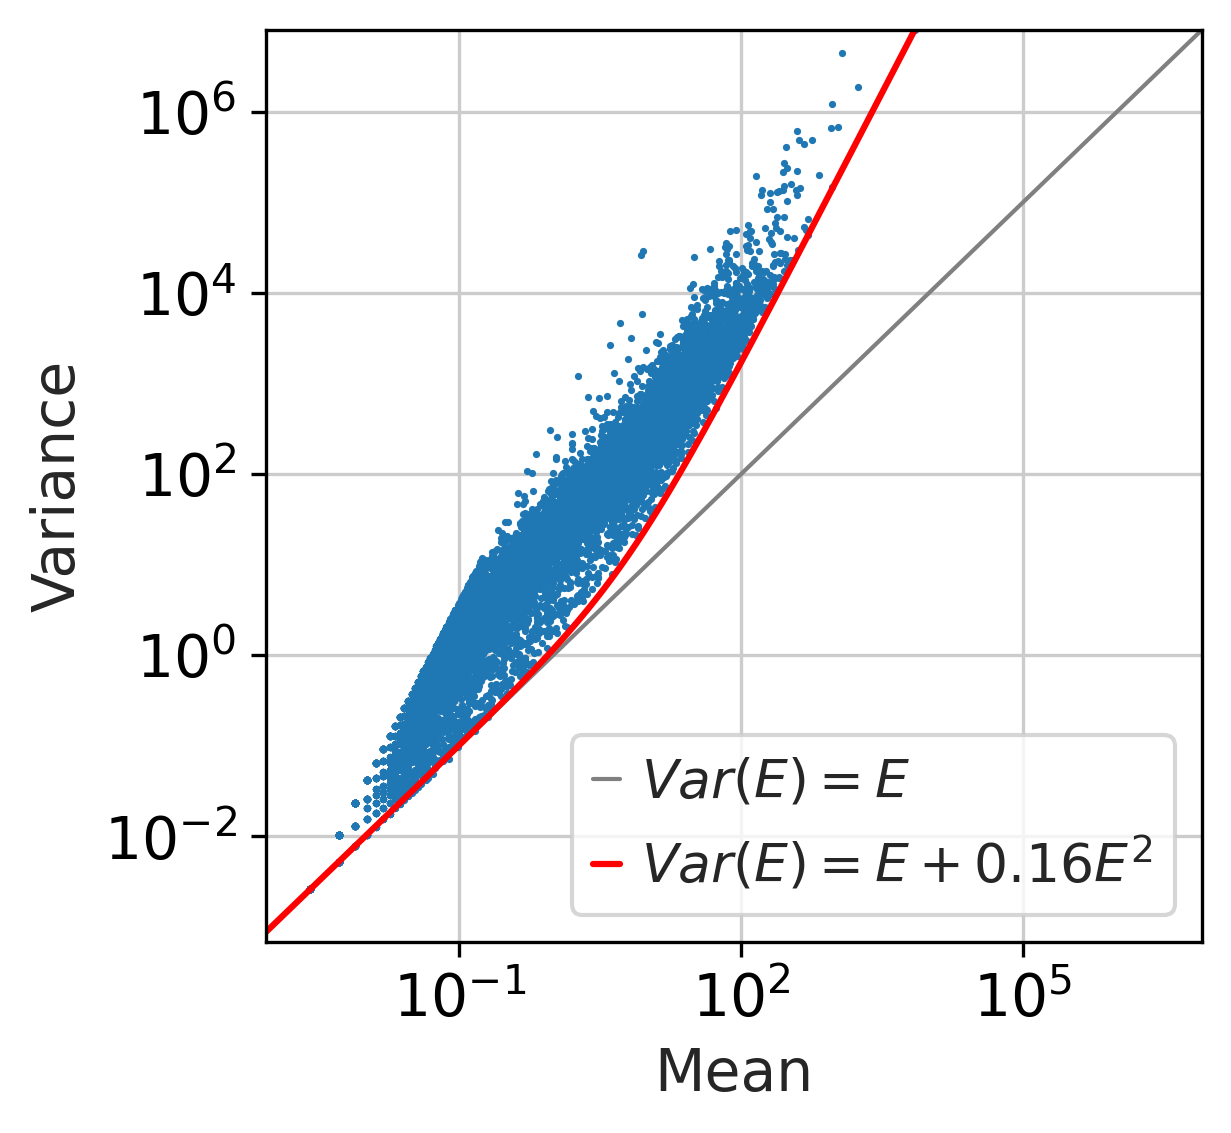

In [ ]:
#До трансформаций
mean_var_plot(adata_smart, fit_NB=True)

Изначально видно, что распределение ведет себя не как у данных 10x. Даже гены с небольшим средним имеют сильную овердисперсию.

Найдем сначала CP10k - необходим для того, чтобы убрать эффект глубины секвенирования библиотеки.

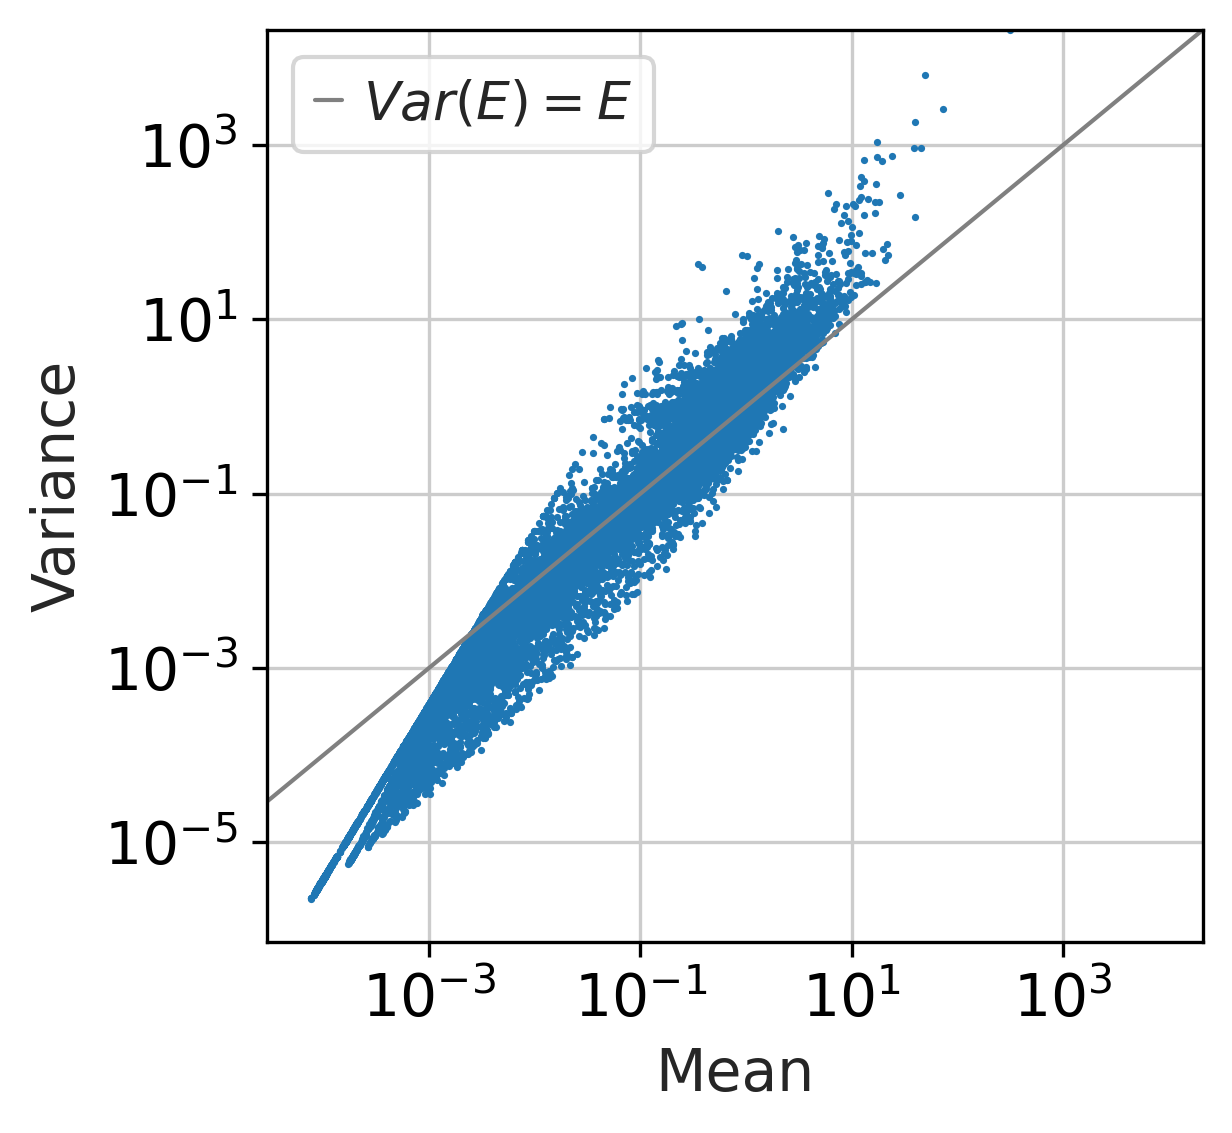

In [ ]:
adata = adata_smart.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
mean_var_plot(adata, log=True)

Построим еще график с домножением на 1e6:

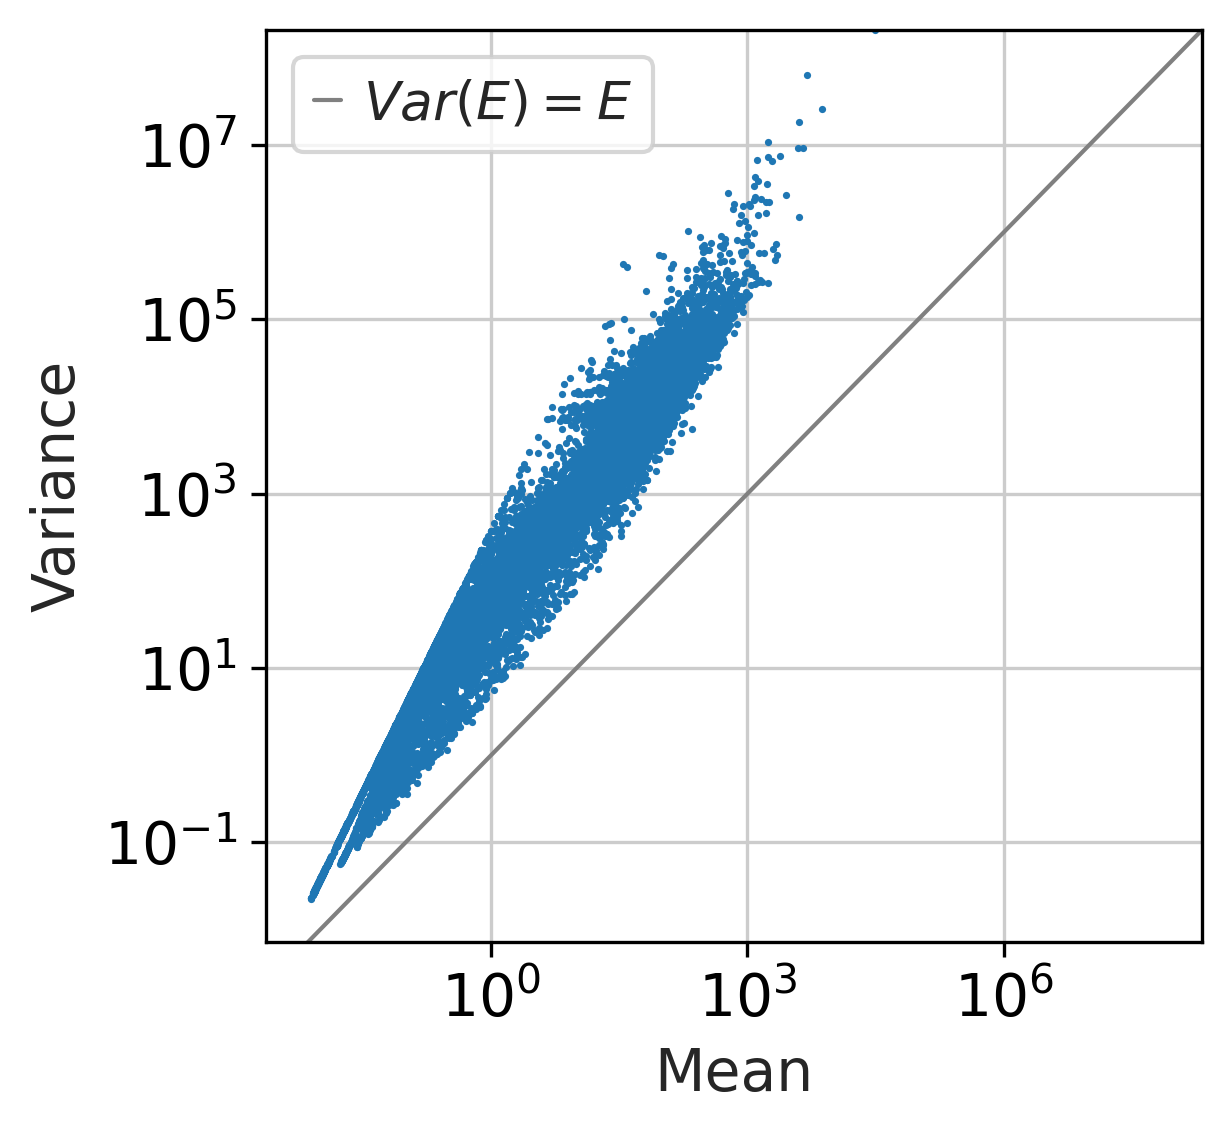

In [ ]:
adata = adata_smart.copy()
sc.pp.normalize_total(adata, target_sum=1e6)
mean_var_plot(adata, log=True)

Теперь лучше видно, что с эффектом овердисперсии мы не справились.

Дальше проведем логарифмирование после нормализации

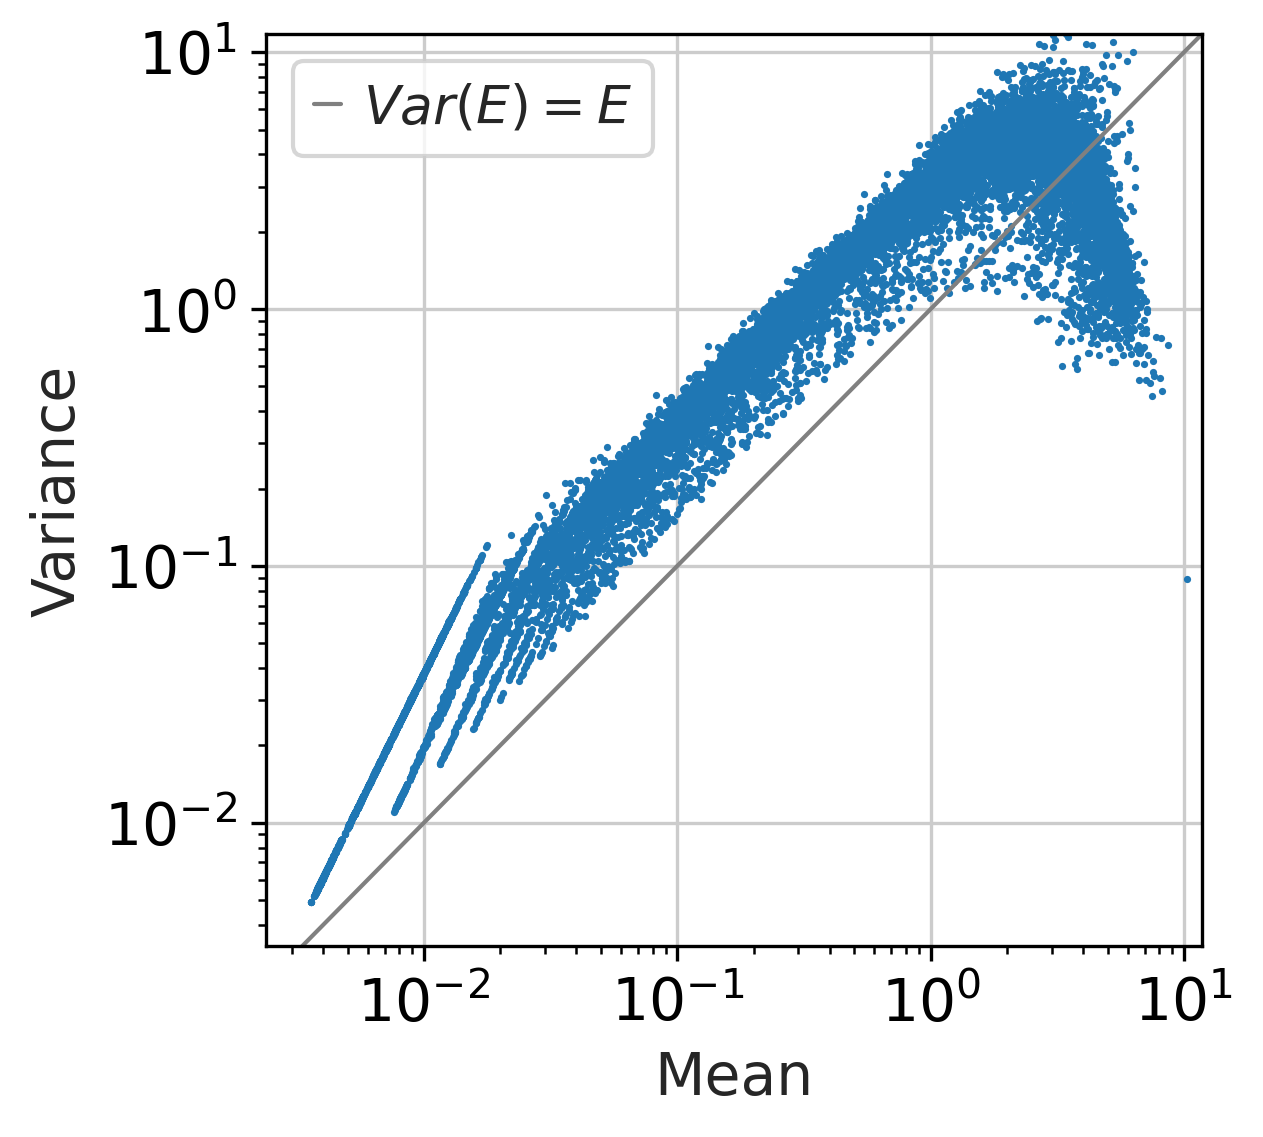

In [ ]:
#сумма при нормализации сводится к 1e6
adata = adata_smart.copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
mean_var_plot(adata, log=True)

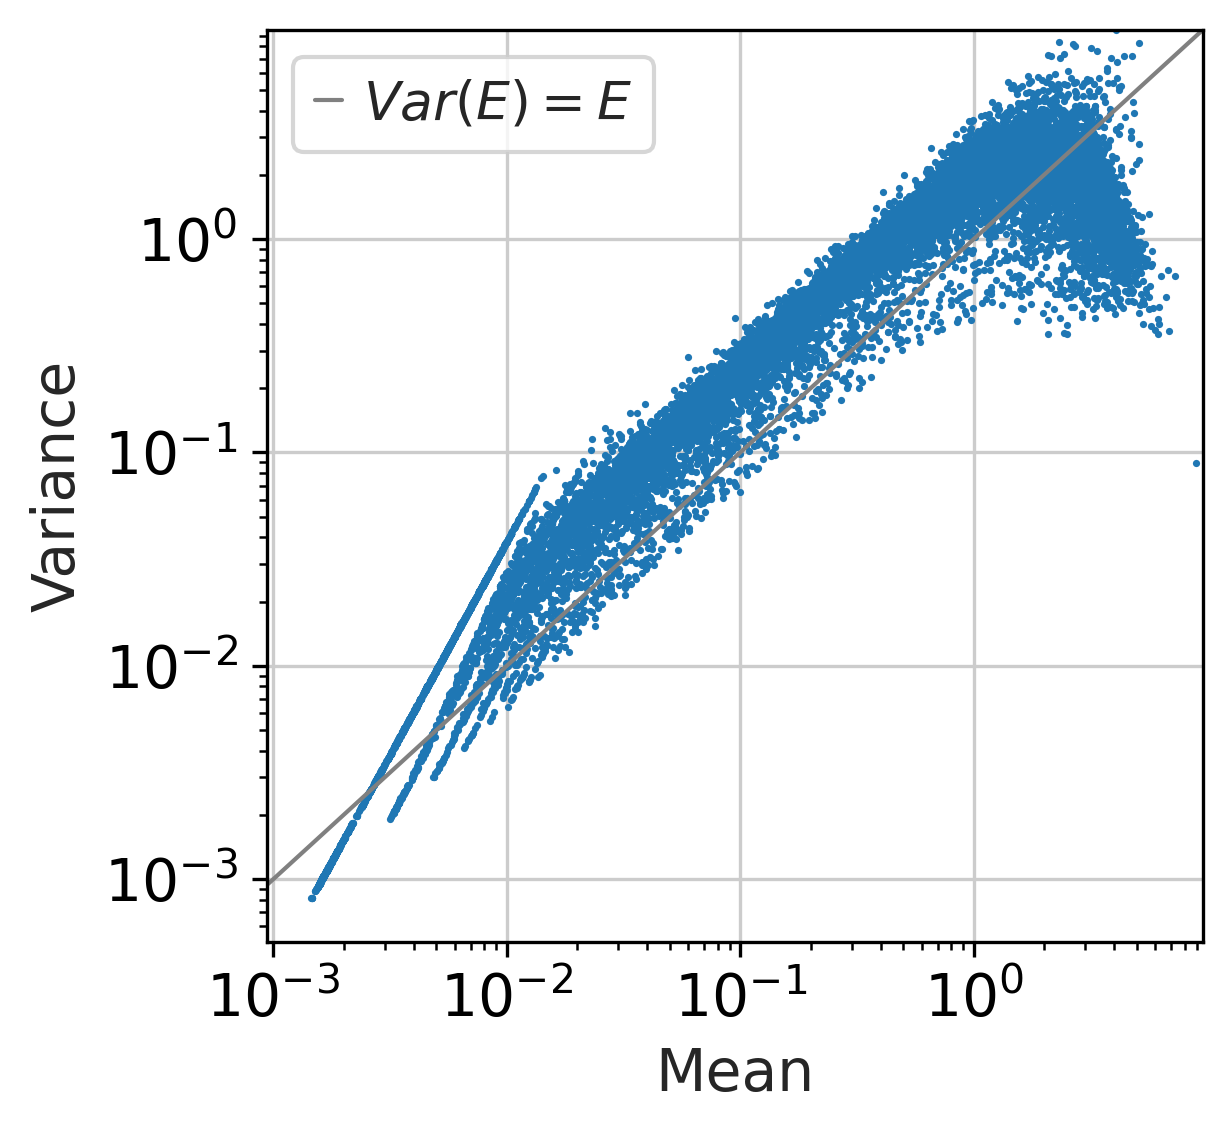

In [ ]:
#сумма при нормализации сводится к медиане
adata = adata_smart.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
mean_var_plot(adata, log=True)

Эффект овердисперсии сохраняется (явно видно, что есть мешающая нам зависимость среднего и дисперсии)

Посмотрим на просто логарифмированные данные (без предварительной нормализации)

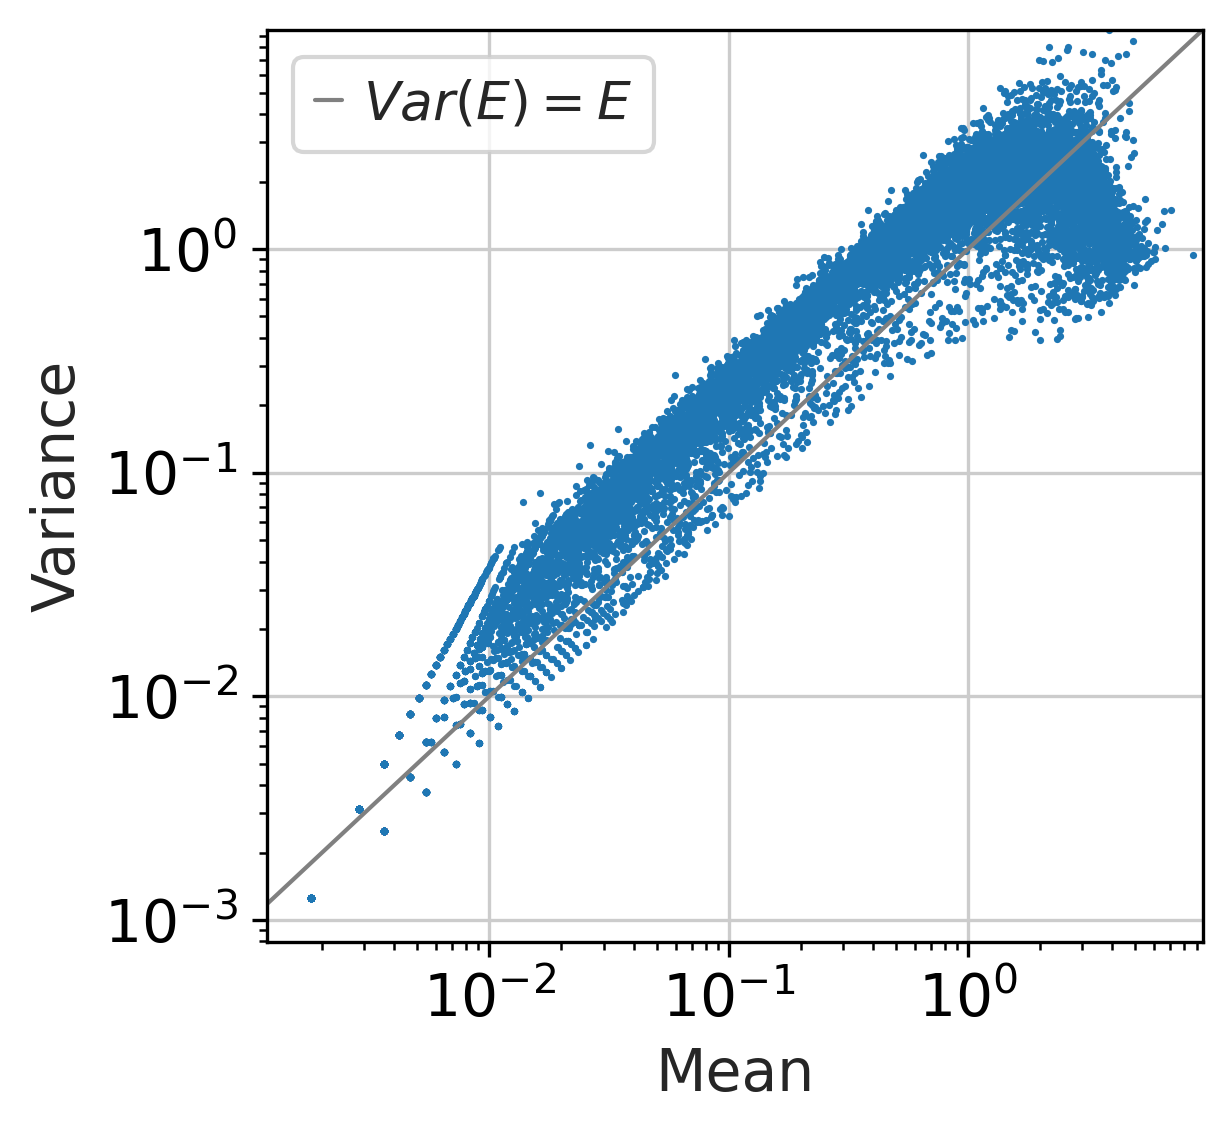

In [ ]:
adata = adata_smart.copy()
sc.pp.log1p(adata)
mean_var_plot(adata, log=True)

Все равно зависимость остается

Далее посмотрим что будет если вместо логарифмирования брать квадратный корень

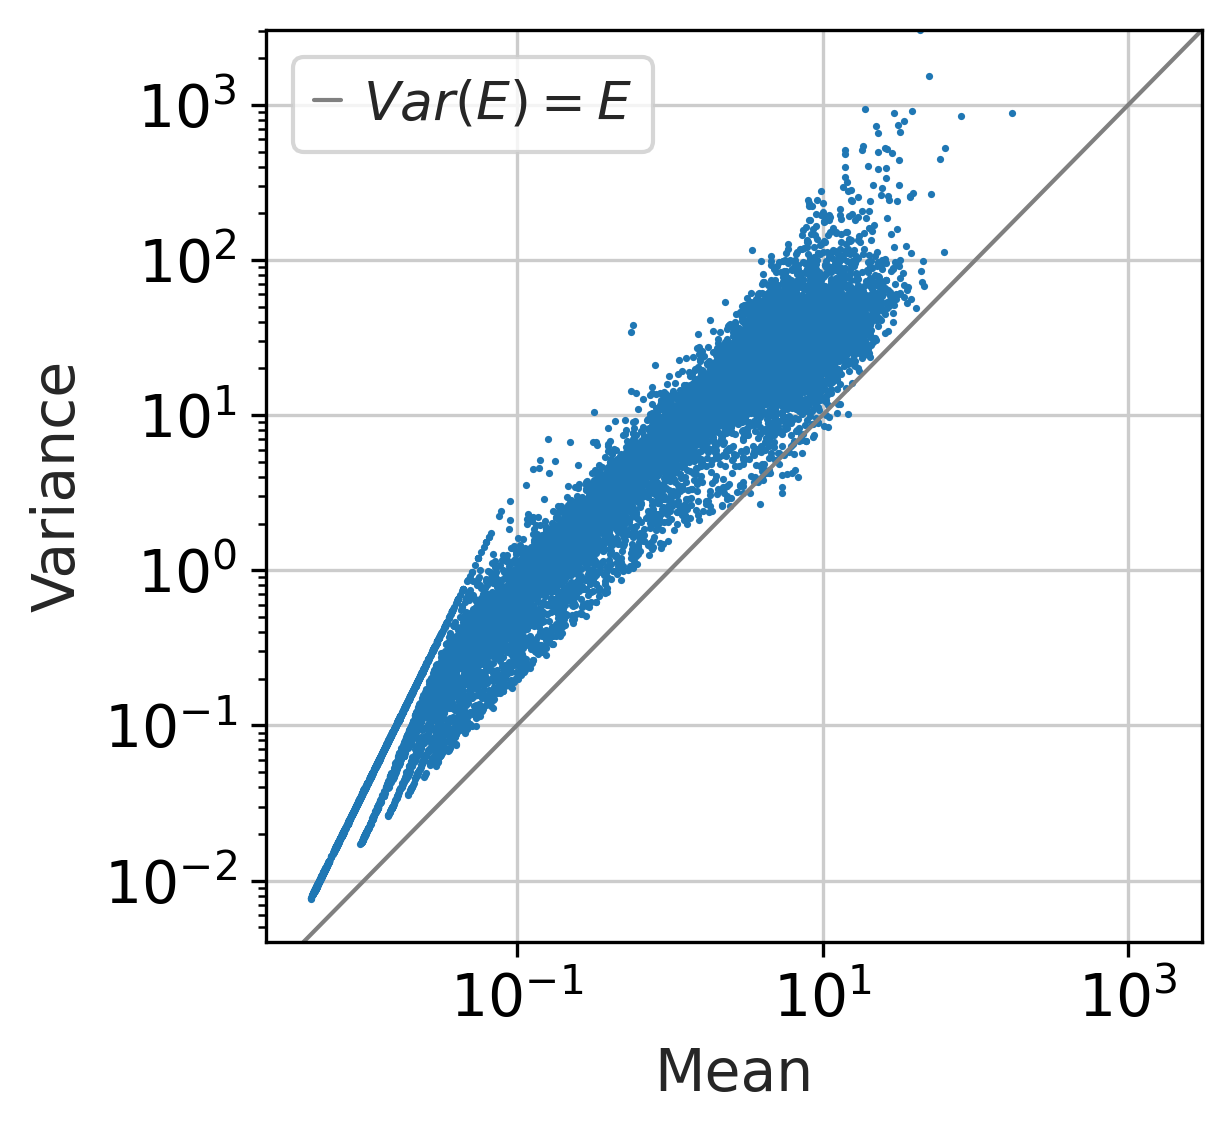

In [ ]:
#с предварительной нормализацией
adata = adata_smart.copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.sqrt(adata)
mean_var_plot(adata, log=True)

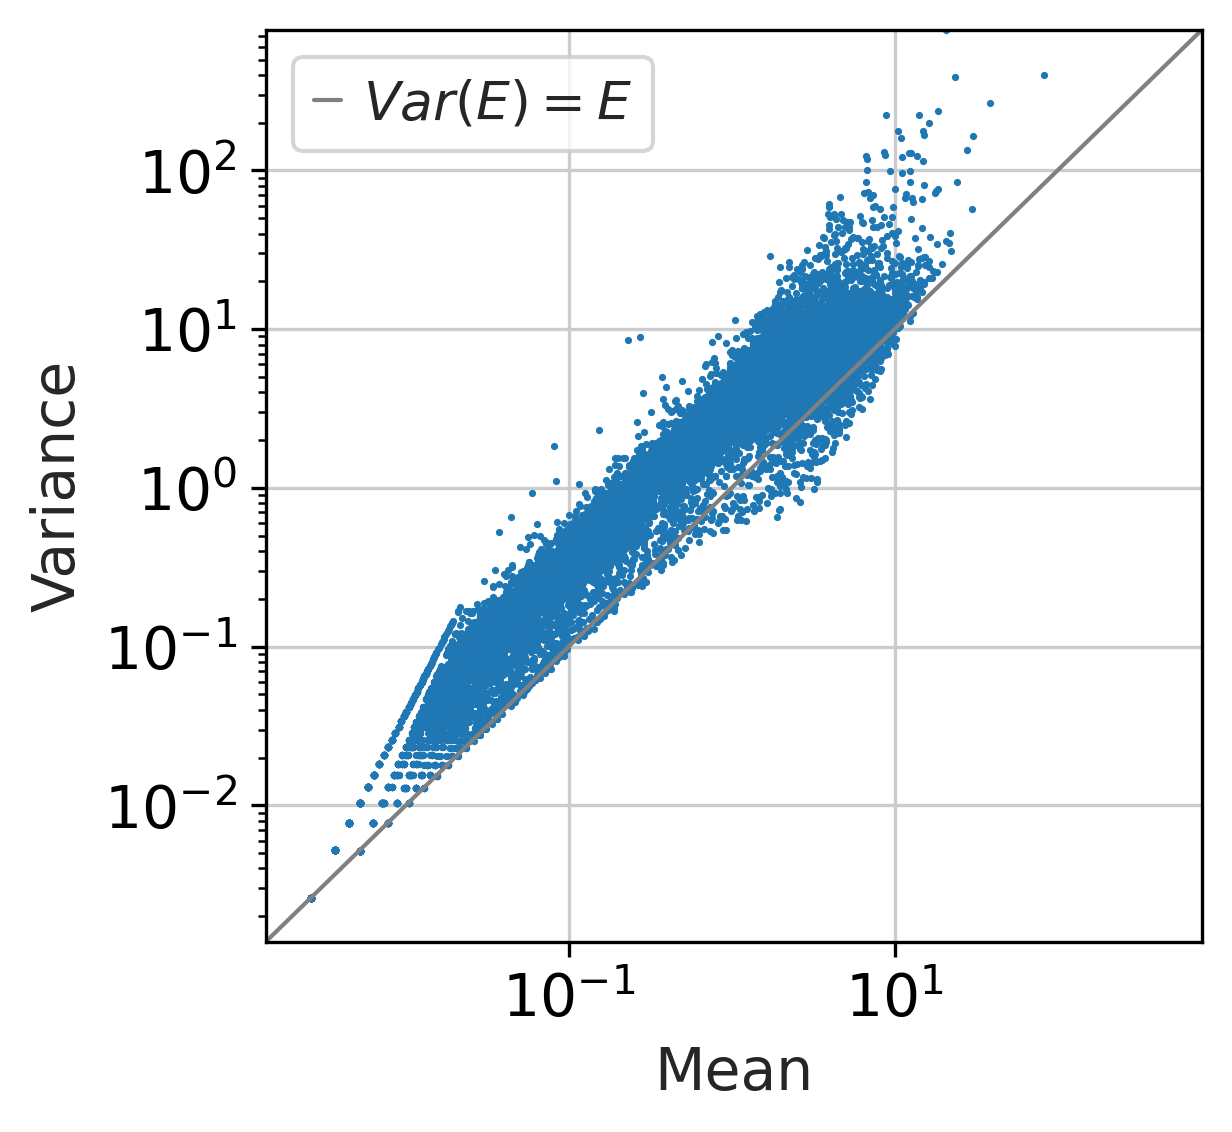

In [ ]:
#без нормализации
adata = adata_smart.copy()
sc.pp.sqrt(adata)
mean_var_plot(adata, log=True)

<b>Выводы:</b> В целом такого рода трансформации вообще не решают проблему овердисперсии. Особенно на данных Smart-seq2, которые распределены сложнее чем NB и поэтому предположения о квадратичной зависимости среднего от дисперсии нам не помогли.

### 2. Постройте постройте аналогичный заданию из занятия боксплот с распределением квардарат коэффециента корреляции между экспрессией гена и глубиной секвенирования клетки, только добавьте туда также и корреляцию для остатков регрессии SCTransform (и Analytic Pearson residuals). Есть ли при таких трансформациях зависимость между глубиной секвенирования клетки и экспрессией генов?

In [ ]:
!gdown "1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=t
To: /content/PBMC_Satija.h5ad
100% 243M/243M [00:00<00:00, 245MB/s]


In [ ]:
adata_10x = sc.read_h5ad("PBMC_Satija.h5ad")
adata_10x = adata_10x[adata_10x.obs.donor == "P1"]
adata = adata_10x.copy()
adata_raw = adata.copy()
adata.var['mean_val'] = adata.X.A.mean(axis=0)
p = adata.var['mean_val'] != 0
adata = adata[:, p]

In [ ]:
ro.globalenv["adata_counts"] = adata
ro.r('SCT.results <- sctransform::vst(assay(adata_counts), vst.flavor="v2")')
var_SCT = ro.r("SCT.results$gene_attr")
SCT = ro.r("SCT.results$y")
cells_SCT = ro.r("SCT.results$cells_step1")
adata_SCT = adata.copy()
adata_SCT = adata_SCT[:, var_SCT.index]
adata_SCT.layers["SCTransform"] = SCT.T

In [ ]:
adata = adata_raw.copy()
adata.obs["total_UMI"] = adata.X.A.sum(axis=1)
n_UMIs = np.array(adata.obs["total_UMI"])

In [ ]:
from scipy.stats import pearsonr
adata = adata_SCT.copy()
adata.obs["total_exp"] = adata.X.A.sum(axis=1)
n_exp = np.array(adata.obs["total_exp"])

In [ ]:
adata_PF = sc.pp.normalize_total(adata, copy=True)
adata_log1pPF = sc.pp.log1p(adata_PF, copy=True)
adata_PFlog1pPF = sc.pp.normalize_total(adata_log1pPF, copy=True)
adata_Peares = sc.experimental.pp.normalize_pearson_residuals(adata, theta = 6.25, copy=True)

results_r2 = pd.DataFrame({
    "PF" : [pearsonr(
        adata_PF[:, gene].X.A.T[0], n_UMIs
    )[0] ** 2 for gene in adata.var_names],
    "log1pPF" : [pearsonr(
        adata_log1pPF[:, gene].X.A.T[0], n_UMIs
    )[0] ** 2 for gene in adata.var_names],
    "PFlog1pPF" : [pearsonr(
        adata_PFlog1pPF[:, gene].X.A.T[0], n_UMIs
    )[0] ** 2 for gene in adata.var_names],
    "Peares" : [pearsonr(
        adata_Peares[:, gene].X.T[0], n_exp
    )[0] ** 2 for gene in adata.var_names],
    "SCT" : [pearsonr(
        adata_SCT.layers["SCTransform"].T[0], n_exp
    )[0] ** 2 for gene in adata.var_names]
}, index=adata.var_names)

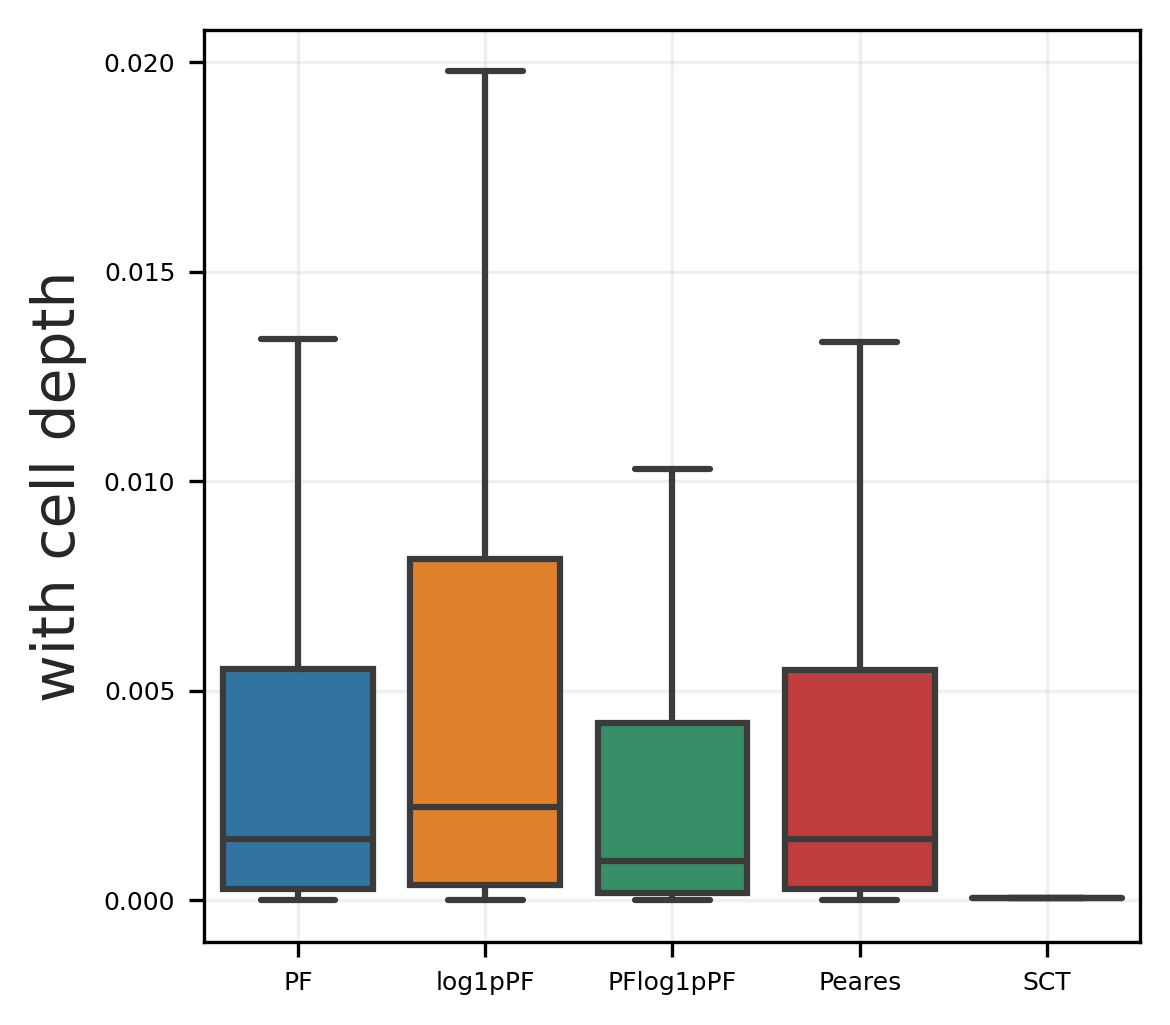

In [ ]:
ax = sns.boxplot(data=results_r2, showfliers=False)
ax.set_ylabel("with cell depth")
plt.setp(ax.get_xticklabels(), fontsize=6)
plt.setp(ax.get_yticklabels(), fontsize=6)
ax.grid(alpha=0.3)